In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(image.size)
    if size > max_size:
        size = max_size

    if shape:
        transform = transforms.Compose([
            transforms.Resize(shape),
            transforms.ToTensor()
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor()
        ])

    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

# Convert tensor to image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

# Feature extractor
def get_features(image, model, content_layers, style_layers):
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)

        if name == '0' and 'conv1_1' in style_layers:
            features['conv1_1'] = image
        elif name == '5' and 'conv2_1' in style_layers:
            features['conv2_1'] = image
        elif name == '10' and 'conv3_1' in style_layers:
            features['conv3_1'] = image
        elif name == '19' and 'conv4_1' in style_layers:
            features['conv4_1'] = image
        elif name == '21' and 'conv4_2' in content_layers:
            features['conv4_2'] = image
        elif name == '28' and 'conv5_1' in style_layers:
            features['conv5_1'] = image

    return features

# Gram Matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Load content and style images
content = load_image("content1.jpg")
style = load_image("style.jpg", shape=content.shape[-2:])

# Load VGG19
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad = False

# Layer settings
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Feature maps
content_features = get_features(content, vgg, content_layers, style_layers)
style_features = get_features(style, vgg, content_layers, style_layers)

# Gram matrices for style
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initialize target image
target = content.clone().requires_grad_(True)

# Optimizer and weights
optimizer = optim.Adam([target], lr=0.003)
style_weight = 1e6
content_weight = 1

# Optimization loop
for step in range(1, 501):
    target_features = get_features(target, vgg, content_layers, style_layers)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_features[layer])
        layer_loss = torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss / (target_feature.shape[1] ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item():.4f}")

# Save and display final image
final_image = im_convert(target)
final_image.save("styled_output.jpg")
final_image.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 100, Total Loss: 229022576.0000
Step 200, Total Loss: 97236056.0000
Step 300, Total Loss: 58720492.0000
Step 400, Total Loss: 41110164.0000
Step 500, Total Loss: 31450256.0000


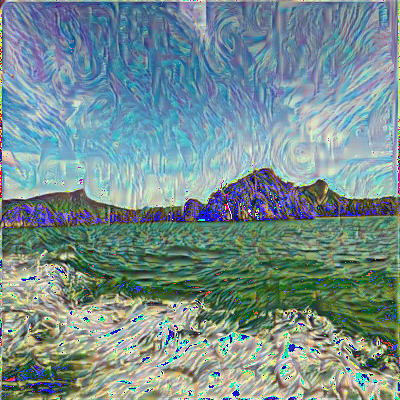

In [7]:
# Convert and save final image
from IPython.display import display
from google.colab import files

styled_image = im_convert(target)
styled_image.save("styled_output.jpg")
display(styled_image)